<b>Heikin Ashi Trading Strategy </b>

This trading strategy combines Live Price and Volume to identify trading opportunites on 1 and 5 minute Time-frames on a Heikin-Ashi Chart. Finally, it calculates cumulative returns for historical data of CrudeOil, Bitcoin, and Etherium.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import pyfolio as pf

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [9]:
class Heikin_Ashi_Strategy:
    
    def __init__(self, data):
        self.data = data
        self.fetchdata()
        self.Heikin_Ashi()
        self.Cols()
        self.Low_Volume_Speed_Entry()
        self.Stop_Loss_Speed()
        self.Stop_Loss_Speed()
        self.Target_Speed()
        self.Position_Speed()
        self.Speed_BNH_Returns()
        self.Speed_Strategy_Returns()
        self.Pullback_Entry()
        self.Stop_Loss_Pullback()
        self.Target_Pullback()
        self.Position_Pullback()
        self.PullBack_BNH_Returns()
        self.Pullback_Strategy_Returns()
        self.Final_Position()
        self.Final_BNH_Returns()
        self.Strategy_Returns()
        self.Plotting()
         
        
    def fetchdata(self):
        self.df = self.data
        
    # Transforming Candlestick data to Heikin Ashi Data.
        
    def Heikin_Ashi(self):
        self.df['Close1'] = 0.25*(self.df['Open'] + self.df['High'] + self.df['Low'] + self.df['Close'])
        self.df['Open1'] = 0.5*(self.df['Open'].shift(1) + self.df['Close'].shift(1))
        self.df['High1'] = self.df['High']
        self.df['High1'] = np.where((self.df['Open1'] > self.df['High']) & (self.df['Open1'] > self.df['Close1']), self.df['Open1'], self.df['High1'])
        self.df['High1'] = np.where((self.df['Close1'] > self.df['High']) & (self.df['Close1'] > self.df['Open1']), self.df['Close1'], self.df['High1'])
        self.df['Low1'] = self.df['Low']
        self.df['Low1'] = np.where((self.df['Open1'] < self.df['Low']) & (self.df['Open1'] < self.df['Close1']), self.df['Open1'], self.df['Low1'])
        self.df['Low1'] = np.where((self.df['Close1'] < self.df['Low']) & (self.df['Close1'] < self.df['Open1']), self.df['Close1'], self.df['Low1'])
    
    # Deleting Candlestick data values.
    
    def Cols(self):
        del self.df['Open']
        del self.df['Close']
        del self.df['High']
        del self.df['Low']
        
    # Calculating Signals, setting up Stop Loss, Take Profit, taking Position, and evaluating Buy and Hold and Strategy Returns for Speed Candle Strategy.

    def Low_Volume_Speed_Entry(self):
        self.df['Flag'] = np.where((self.df['Open1'] == self.df['High1']) & (self.df['Open1'].shift(1) == self.df['High1'].shift(1)) & 
                                  (self.df['Open1'] > self.df['Close1']) & (self.df['Open1'].shift(1) > self.df['Close1'].shift(1)) &
                                  (self.df['High1'] < self.df['High1'].shift(1)) & (self.df['Low1'] < self.df['Low1'].shift(1)) & 
                                  (self.df['Volume'] < self.df['Volume'].shift(1)), 1, 0)
        self.df['Flag'] = np.where((self.df['Open1'] == self.df['Low1']) & 
                                  (self.df['Open1'].shift(1) == self.df['Low1'].shift(1)) & 
                                  (self.df['Open1'] < self.df['Close1']) & 
                                  (self.df['Open1'].shift(1) < self.df['Close1'].shift(1)) &
                                  (self.df['High1'] > self.df['High1'].shift(1)) & 
                                  (self.df['Low1'] > self.df['Low1'].shift(1)) & 
                                  (self.df['Volume'] < self.df['Volume'].shift(1)), -1, self.df['Flag'])
        self.df['Signal'] = np.where(((self.df['Flag'].shift(1) == 1) & (self.df['High1'] > self.df['High1'].shift(1))) |
                                    ((self.df['Flag'].shift(2) == 1) & (self.df['High1'] > self.df['High1'].shift(2))) |
                                    ((self.df['Flag'].shift(3) == 1) & (self.df['High1'] > self.df['High1'].shift(3))), 1, 0)
        self.df['Signal'] = np.where(((self.df['Flag'].shift(1) == -1) & (self.df['Low1'] < self.df['Low1'].shift(1))) |
                                    ((self.df['Flag'].shift(2) == -1) & (self.df['Low1'] < self.df['Low1'].shift(2))) |
                                    ((self.df['Flag'].shift(3) == -1) & (self.df['Low1'] < self.df['Low1'].shift(3))), -1, self.df['Signal'])
        
    def Stop_Loss_Speed(self):
        self.df['Stop'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(1) == 1), self.df['Low1'].shift(1), 0)
        self.df['Stop'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(2) == 1), self.df['Low1'].shift(2), self.df['Stop'])
        self.df['Stop'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(3) == 1), self.df['Low1'].shift(3), self.df['Stop'])
        self.df['Stop'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(1) == -1), self.df['High1'].shift(1), self.df['Stop'])
        self.df['Stop'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(2) == -1), self.df['High1'].shift(2), self.df['Stop'])
        self.df['Stop'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(3) == -1), self.df['High1'].shift(3), self.df['Stop'])
        self.df['Stop1'] = self.df['Stop'].replace(to_replace = 0, method = 'ffill')
    
    def Target_Speed(self):
        self.df['Target'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(1) == 1), self.df['High1'].shift(1) + 2*(self.df['High1'].shift(1) - self.df['Low1'].shift(1)), 0)
        self.df['Target'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(2) == 1), self.df['High1'].shift(2) + 2*(self.df['High1'].shift(2) - self.df['Low1'].shift(2)), self.df['Target'])
        self.df['Target'] = np.where((self.df['Signal'] == 1) & (self.df['Flag'].shift(3) == 1), self.df['High1'].shift(3) + 2*(self.df['High1'].shift(3) - self.df['Low1'].shift(3)), self.df['Target'])
        self.df['Target'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(1) == -1), self.df['Low1'].shift(1) - 2*(self.df['High1'].shift(1) - self.df['Low1'].shift(1)), self.df['Target'])
        self.df['Target'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(2) == -1), self.df['Low1'].shift(2) - 2*(self.df['High1'].shift(2) - self.df['Low1'].shift(2)), self.df['Target'])
        self.df['Target'] = np.where((self.df['Signal'] == -1) & (self.df['Flag'].shift(3) == -1), self.df['Low1'].shift(3) - 2*(self.df['High1'].shift(3) - self.df['Low1'].shift(3)), self.df['Target'])
        self.df['Target1'] = self.df['Target'].replace(to_replace = 0, method = 'ffill')
        
    def Position_Speed(self):
        self.df['Position'] = self.df['Signal'].replace(to_replace = 0, method = 'ffill')
        self.df['Position1'] = np.where((self.df['Position'] == 1) & ((self.df['High1'] >= self.df['Target1']) | (self.df['Low1'] <= self.df['Stop1'])), 0, self.df['Position'])
        self.df['Position1'] = np.where((self.df['Position'] == -1) & ((self.df['Low1'] <= self.df['Target1']) | (self.df['High1'] >= self.df['Stop1'])), 0, self.df['Position1'])
        for i in range(len(self.df)):
            self.df['Position1'] = np.where((self.df['Position1'].shift(1) == 0) & (self.df['Signal'] == 0), 0, self.df['Position1'])
    
    def Speed_BNH_Returns(self):
        self.df['BNH1'] = np.log(self.df['Close1'] / self.df['Close1'].shift(1))
        self.df['BNH1'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == -1) & (self.df['Low1'] <= self.df['Target1']),
                                 np.log(self.df['Target1'] / self.df['Close1'].shift(1)), self.df['BNH1'])
        self.df['BNH1'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == -1) & (self.df['High1'] >= self.df['Stop1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH1'])
        self.df['BNH1'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == 1) & (self.df['Low1'] <= self.df['Stop1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH1'])
        self.df['BNH1'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == 1) & (self.df['High1'] >= self.df['Target1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH1'])
    
    def Speed_Strategy_Returns(self):
        self.df['Strategy Returns1'] = self.df['BNH1'] * self.df['Position1'].shift(1)
        
    # Calculating Signals, setting up Stop Loss, Take Profit, taking Position, and evaluating Buy and Hold and Strategy Returns for Ranging Candle Strategy.
        
    def Pullback_Entry(self):
        self.df['Flag1'] = np.where((self.df['High1'].shift(1) != self.df['Close1'].shift(1)) &
                                   (self.df['Low1'].shift(1) != self.df['Open1'].shift(1)) &
                                   (self.df['High1'].shift(1) != self.df['Open1'].shift(1)) &
                                   (self.df['Close1'].shift(1) != self.df['Low1'].shift(1)) & 
                                   (self.df['Volume'].shift(1) < self.df['Volume'].shift(2)) &
                                   (self.df['High1'] > self.df['High1'].shift(1)) &
                                   (self.df['Open1'] < self.df['Close1']), 1, 0)
        self.df['Flag1'] = np.where((self.df['High1'].shift(1) != self.df['Close1'].shift(1)) &
                                   (self.df['Low1'].shift(1) != self.df['Open1'].shift(1)) &
                                   (self.df['High1'].shift(1) != self.df['Open1'].shift(1)) &
                                   (self.df['Close1'].shift(1) != self.df['Low1'].shift(1)) & 
                                   (self.df['Volume'].shift(1) < self.df['Volume'].shift(2)) &
                                   (self.df['Low1'] < self.df['Low1'].shift(1)) &
                                   (self.df['Open1'] > self.df['Close1']), -1, self.df['Flag1'])
        self.df['Signal1'] = np.where((self.df['Flag1'].shift(1) == -1) & (self.df['High1'] >= self.df['Open1'].shift(2)) & (self.df['Open1'] > self.df['Close1']), -1, 0)
        self.df['Signal1'] = np.where((self.df['Flag1'].shift(1) == 1) & (self.df['Low1'] <= self.df['Open1'].shift(2)) & (self.df['Open1'] < self.df['Close1']), 1, self.df['Signal1'])
    
    def Stop_Loss_Pullback(self):
        self.df['Stop2'] = np.where((self.df['Signal1'] == 1) , self.df['Low1'].shift(2), 0)
        self.df['Stop2'] = np.where((self.df['Signal1'] == -1), self.df['High1'].shift(2), self.df['Stop2'])
        self.df['Stop3'] = self.df['Stop2'].replace(to_replace = 0, method = 'ffill')
    
    def Target_Pullback(self):
        self.df['Target2'] = np.where((self.df['Signal1'] == 1) & (self.df['Flag1'].shift(1) == 1), self.df['Open1'].shift(2) + 2*(self.df['Open1'].shift(2) - self.df['Low1'].shift(2)), 0)
        self.df['Target2'] = np.where((self.df['Signal1'] == -1) & (self.df['Flag1'].shift(1) == -1), self.df['Open1'].shift(2) - 2*(self.df['High1'].shift(2) - self.df['Open1'].shift(2)), self.df['Target2'])
        self.df['Target3'] = self.df['Target2'].replace(to_replace = 0, method = 'ffill')
    
    def Position_Pullback(self):
        self.df['Position2'] = self.df['Signal1'].replace(to_replace = 0, method = 'ffill')
        self.df['Position3'] = np.where((self.df['Position2'] == 1) & ((self.df['High1'] >= self.df['Target3']) | (self.df['Low1'] <= self.df['Stop3'])), 0, self.df['Position2'])
        self.df['Position3'] = np.where((self.df['Position2'] == -1) & ((self.df['Low1'] <= self.df['Target3']) | (self.df['High1'] >= self.df['Stop3'])), 0, self.df['Position3'])
        for i in range(len(self.df)):
            self.df['Position3'] = np.where((self.df['Position3'].shift(1) == 0) & (self.df['Signal1'] == 0), 0, self.df['Position3'])
        
    def PullBack_BNH_Returns(self):
        self.df['BNH2'] = np.log(self.df['Close1'] / self.df['Close1'].shift(1))
        self.df['BNH2'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == -1) & (self.df['Low1'] <= self.df['Target3']),
                                 np.log(self.df['Target3'] / self.df['Close1'].shift(1)), self.df['BNH2'])
        self.df['BNH2'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == -1) & (self.df['High1'] >= self.df['Stop3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH2'])
        self.df['BNH2'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == 1) & (self.df['Low1'] <= self.df['Stop3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH2'])
        self.df['BNH2'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == 1) & (self.df['High1'] >= self.df['Target3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH2'])
        
    def Pullback_Strategy_Returns(self):
        self.df['Strategy Returns2'] = self.df['BNH2'] * self.df['Position3'].shift(1)
        
    # Calculating Final Positions and Returns by combining Signals from both strategies.
        
    def Final_Position(self):
        self.df['FPosition'] = self.df['Position1']
        self.df['FPosition'] = np.where((self.df['Position1'] == 0), self.df['Position3'], self.df['Position1'])

    def Final_BNH_Returns(self):
        self.df['BNH'] = np.log(self.df['Close1'] / self.df['Close1'].shift(1))
        self.df['BNH'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == -1) & (self.df['Low1'] <= self.df['Target3']),
                                 np.log(self.df['Target3'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == -1) & (self.df['High1'] >= self.df['Stop3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == 1) & (self.df['Low1'] <= self.df['Stop3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position3'] == 0) & (self.df['Position3'].shift(1) == 1) & (self.df['High1'] >= self.df['Target3']),
                                 np.log(self.df['Stop3'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.log(self.df['Close1'] / self.df['Close1'].shift(1))
        self.df['BNH'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == -1) & (self.df['Low1'] <= self.df['Target1']),
                                 np.log(self.df['Target1'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == -1) & (self.df['High1'] >= self.df['Stop1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == 1) & (self.df['Low1'] <= self.df['Stop1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH'])
        self.df['BNH'] = np.where((self.df['Position1'] == 0) & (self.df['Position1'].shift(1) == 1) & (self.df['High1'] >= self.df['Target1']),
                                 np.log(self.df['Stop1'] / self.df['Close1'].shift(1)), self.df['BNH'])
        
    def Strategy_Returns(self):
        self.df['Strategy Returns'] = self.df['BNH'] * self.df['FPosition'].shift(1)  
        print("Total Return:", self.df['Strategy Returns'].sum()*100)
        
    def Plotting(self):
        self.df[['BNH','Strategy Returns']].cumsum().plot(figsize=(15,6),grid = True)
        
    np.seterr(divide = 'ignore')

I have imported data from TradingView.com as it provides Real Market Time data and is more efficient than Yahoo Finance.

Total Return: 0.16838301042468376
Total Return: 0.2893720604457912
Total Return: -0.7952829920780159
Total Return: 1.6300962448176077
Total Return: -0.6224731206105452
Total Return: 2.00253628191342


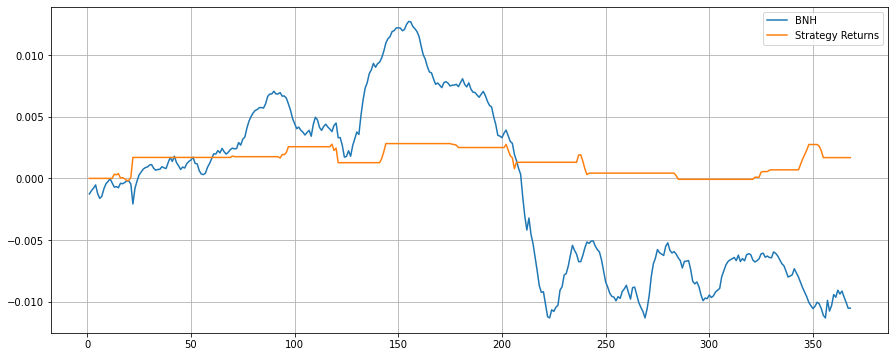

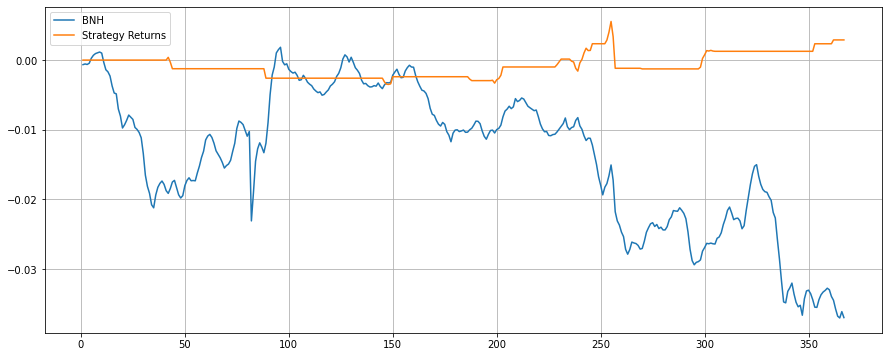

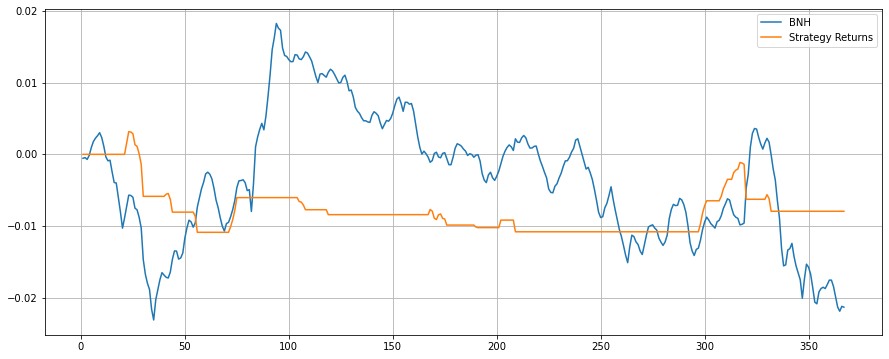

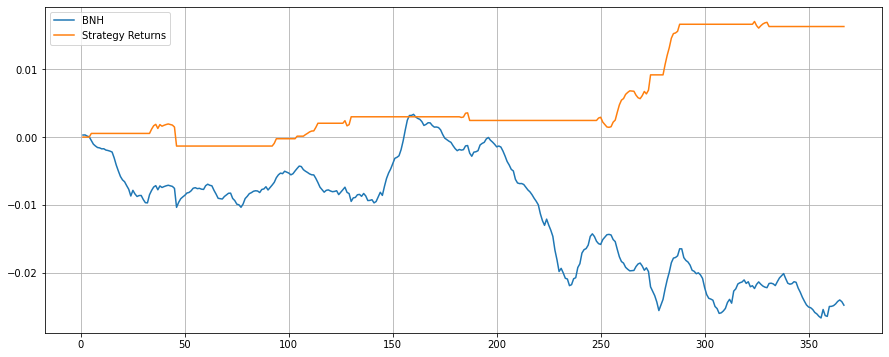

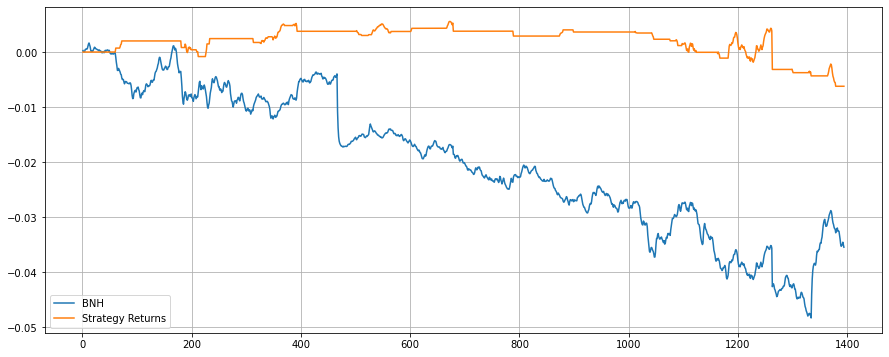

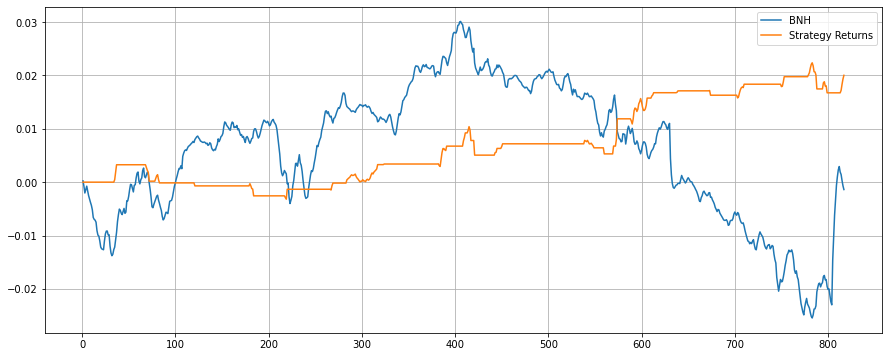

In [10]:
BTCUSD1 = pd.read_csv('/Users/macbookair/Desktop/Excel/BITSTAMP_BTCUSD, 1.csv')
BTCUSD5 = pd.read_csv('/Users/macbookair/Desktop/Excel/BITSTAMP_BTCUSD, 5.csv')
ETHUSD1 = pd.read_csv('/Users/macbookair/Desktop/Excel/BITSTAMP_ETHUSD, 5.csv')
ETHUSD5 = pd.read_csv('/Users/macbookair/Desktop/Excel/BITSTAMP_ETHUSD, 1.csv')
CRUOIL1 = pd.read_csv('/Users/macbookair/Desktop/Excel/MCX_CRUDEOILX2021, 1.csv')
CRUOIL5 = pd.read_csv('/Users/macbookair/Desktop/Excel/MCX_CRUDEOILX2021, 5.csv')
data = [BTCUSD1, BTCUSD5, ETHUSD1, ETHUSD5, CRUOIL1, CRUOIL5]
for i in range(len(data)):
    Heikin_Ashi_Strategy(data[i])

The returns seem to be positive and high for such time frames on a 5 minute chart and negative on a 1 minute chart.
It seems reasonable to conclude to follow up with this strategy on a 5 minute chart. Moreover, I didn't fully backtest the data as the maximum drawdown, Sharpe Ratio, Calmar Ratio, and Sortino Ratio values would not reliable for such marginal available data as the standard deviation would be really high.